In [1]:
# Basic python packages
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
import glob
import splitfolders

# General machine learning packages
from sklearn.model_selection import train_test_split

# Packages related to images
from PIL import Image
import PIL

# Packages for neural networks
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Embedding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.models import Model

In [2]:
# Check if GPU works
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def clean_data(path):
    df = pd.read_csv(path)
    df = df[df['Creator'] != ''] 
    df = df[df['Creator'] != 'anoniem']
    df = df[df['Creator'] != 'onbekend']
    df = df[df['Creator'].notna()]
    df = df.replace('Koning, Cornelis (?-1671)', 'Koning, Cornelis')
    return df

def preprocess_data(df, num_artworks = 10):
    df = df.groupby("Creator").filter(lambda x: len(x) >= num_artworks)
    return df

df = clean_data('../Data/Rijksmuseum/xml_files.csv')
rijksdata = preprocess_data(df, 100)

In [4]:
#Paths to different folders/files
image_dir = "../Data/Rijksmuseum/jpg2/"
split_image_dir = "../Data/Rijksmuseum/jpg2_split_100/"
training_path = "../Data/Rijksmuseum/output/train/"
validation_path = "../Data/Rijksmuseum/output/val/"
testing_path = "../Data/Rijksmuseum/output/test/"

img_size = (200, 200) #Size of the input of the neural networks
IMG_SHAPE = img_size + (3,)
batch_size = 256
n_labels = len(rijksdata.groupby('Creator').count())

In [5]:
labels = rijksdata[['Identifier', 'Creator']]
labels

,Identifier,Creator
3,RP-P-1992-35,"Coornhert, Dirck Volckertsz"
4,RP-P-1992-36,"Coornhert, Dirck Volckertsz"
7,RP-P-1992-70,"Hondius, Hendrick (I)"
100,RP-T-1905-158(R),"Fokke, Simon"
101,RP-T-1905-158(V),"Fokke, Simon"
...,...,...
111961,RP-P-OB-103.253,"Galle, Cornelis (I)"
111962,RP-P-OB-103.254,"Galle, Cornelis (I)"
111965,RP-P-OB-103.259,"Natalis, Michel"
111966,RP-P-OB-103.260,"Sadeler, Johann (I)"


# Split
To test our models locally, we must split our data into a train, validation and test set

In [6]:
# splitfolders.ratio(split_image_dir, output="output", seed=1337, ratio=(.7, .1, .2)) 

# Image Loading
Because the dataset is so large, we cant just load it into our memory. Instead we generate batches of images. These images are then altered a little bit to create higher variance between images and artificially increase the size of our training data.

In [7]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

train_datagen = ImageDataGenerator(
        preprocessing_function=normalize,
        shear_range=2,
        zoom_range=0.2,
        rotation_range = 3,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.6,1.3],
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(
        preprocessing_function=normalize)

train_generator = train_datagen.flow_from_directory(
        training_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        testing_path,
        target_size=img_size,
        batch_size=batch_size,
        shuffle=False)

Found 36483 images belonging to 183 classes.
Found 5139 images belonging to 183 classes.
Found 10623 images belonging to 183 classes.


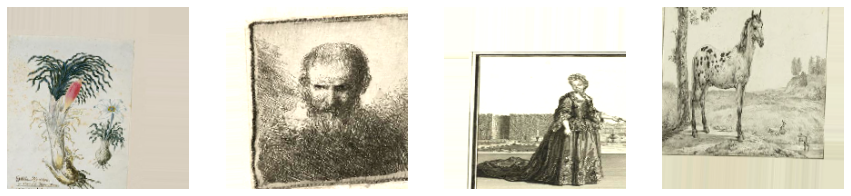

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

    # convert to unsigned integers for plotting
    image = next(train_generator)[0][0]
    # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
    image = np.squeeze(image) * 0.5 + 0.5
    # plot raw pixel data
    ax[i].imshow(image)
    ax[i].axis('off')

In [9]:
def train_model(model, steps_per_epoch=150, epochs=5, validation_steps=70, workers=7, checkpoint_loc=""):
    """
    Trains a given model

    :steps_per_epoch: Amount of batches uploaded per epoch. Cant be higher than +- 200
    :epochs: Amount of times the model trains on the data
    :validation_steps: Amount of batches used for validation. Cant be higher than +- 50
    :workers: Amount of processes used to load the data
    :checkpoint_loc: Place for the model checkpoints to be saved
    :return: The trained model and some training data
    """ 
    # Create a callback that saves the model's weights
#     cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_loc,
#                                                      save_weights_only=True,
#                                                      verbose=1)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_loc,
                                                     monitor='acc',
                                                     save_weights_only=True)
#     cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_loc, 
#                                                      monitor='acc', 
#                                                      save_weights_only=True, 
#                                                      save_best_only=True, 
#                                                      mode='max')

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    begin_time = datetime.datetime.now()
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps, workers=workers, callbacks=[cp_callback, early_stopping])
    print(datetime.datetime.now() - begin_time)
    return (model, history)

In [10]:
def plot_history(history):
    #Plots the training data.
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show() 

# EfficientNet model:

In [36]:
def make_model_b0(n_labels):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                          include_top=False,
                          weights='imagenet')

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    dropout_layer = tf.keras.layers.Dropout(0.2)
    prediction_layer = tf.keras.layers.Dense(n_labels, activation="softmax")
    
    base_model.trainable = True
    set_trainable = False

    for layer in base_model.layers:
        if layer.name == 'block6d_se_excite':
            set_trainable = True
        if set_trainable:
            if not isinstance(layer, BatchNormalization):
                layer.trainable = True
            else:
                layer.trainable = False
        else:
            layer.trainable = False
            
    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      dropout_layer,
      prediction_layer
    ])
            
    for layer in model.layers[-3:]:
        layer.trainable=True

    base_learning_rate = 1e-4
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])
    return model

model = make_model_b0(n_labels)
# model.summary()

In [34]:
def make_model_b7(n_labels):
    base_model = tf.keras.applications.EfficientNetB7(input_shape=IMG_SHAPE,
                          include_top=False,
                          weights='imagenet')

    pretrained_model = base_model
    pretrained_model.trainable=True
    set_trainable=False

    for layer in pretrained_model.layers:
        if layer.name == 'block7c_project_conv':
            set_trainable=True
        if set_trainable:
            layer.trainable=True
        else:
            layer.trainable=False


    model = tf.keras.Sequential([
        pretrained_model,
        MaxPooling2D(name="MaxPool_"),
        Dropout(0.2, name="dropout_out"),
        Flatten(),
        Dense(n_labels, activation='softmax')
    ])
            
#     for layer in model.layers[-3:]:
#         layer.trainable=True

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])
    return model

# model = make_model_b7(n_labels)

In [37]:
STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size

model, history = train_model(model, steps_per_epoch=STEP_SIZE_TRAIN, epochs=20, validation_steps=STEP_SIZE_VALID, checkpoint_loc="../Model_weights/EfficientNetB0model/")


Epoch 1/20
142/142 [==============================] - 149s 1000ms/step - loss: 5.0069 - accuracy: 0.0337 - val_loss: 4.9614 - val_accuracy: 0.0375
Epoch 2/20
142/142 [==============================] - 128s 872ms/step - loss: 4.9752 - accuracy: 0.0372 - val_loss: 4.9594 - val_accuracy: 0.0371
Epoch 3/20
142/142 [==============================] - 139s 951ms/step - loss: 4.9720 - accuracy: 0.0368 - val_loss: 4.9570 - val_accuracy: 0.0375
Epoch 4/20
142/142 [==============================] - 118s 802ms/step - loss: 4.9695 - accuracy: 0.0366 - val_loss: 4.9500 - val_accuracy: 0.0373
Epoch 5/20
142/142 [==============================] - 118s 802ms/step - loss: 4.9654 - accuracy: 0.0366 - val_loss: 4.9443 - val_accuracy: 0.0443
Epoch 6/20
142/142 [==============================] - 127s 862ms/step - loss: 4.9563 - accuracy: 0.0412 - val_loss: 4.9078 - val_accuracy: 0.0576
Epoch 7/20
142/142 [==============================] - ETA: 0s - loss: 4.9374 - accuracy: 0.0446

KeyboardInterrupt: 

In [ ]:
plot_history(history)

In [20]:
# Save model
model.save("models/_EfficientNetB7model")

# Load model
# model = tf.keras.models.load_model('./models/_EfficientNetB0model')
# EfficientNetmodel.load_weights('../Model_weights/EfficientNetB0model/')


INFO:tensorflow:Assets written to: models/_EfficientNetB0model\assets


# Predict the test set
We also have to predict the real test set

In [22]:
def predict_test(model, labels):
    preds = model.predict(test_generator)
    preds_cls_idx = preds.argmax(axis=-1)
    idx_to_cls = {v: k for k, v in train_generator.class_indices.items()}
    preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
    filenames_to_cls = list(zip(test_generator.filenames, preds_cls))
    
    l = []
    n = []
    t = []
    for p in filenames_to_cls:
        n.append(p[0].split("\\")[-1][:-4])
        l.append(p[1])
        t.append(labels[labels['Identifier'] == p[0].split("\\")[-1][:-4]]['Creator'].values[0])
    return pd.DataFrame(list(zip(n, l, t)), columns=['img_name', 'predicted label', 'true label'])

res = predict_test(model, labels)

In [23]:
res

,img_name,predicted label,true label
0,RP-P-H-OB-11.105,"Luyken, Jan","Aldegrever, Heinrich"
1,RP-P-H-OB-11.107,"Luyken, Jan","Aldegrever, Heinrich"
2,RP-P-H-OB-11.108,"Luyken, Jan","Aldegrever, Heinrich"
3,RP-P-H-Z-135,"Luyken, Jan","Aldegrever, Heinrich"
4,RP-P-H-Z-136,"Luyken, Jan","Aldegrever, Heinrich"
...,...,...,...
10618,NG-2011-31-4,"Luyken, Jan",Woodbury & Page
10619,NG-2011-31-42,"Luyken, Jan",Woodbury & Page
10620,NG-2011-31-48,"Luyken, Jan",Woodbury & Page
10621,NG-2011-31-5,"Luyken, Jan",Woodbury & Page


In [24]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(res['true label'], res['predicted label'])
accuracy

0.03643038689635696

In [54]:
res[['predicted label', 'true label']]

,predicted label,true label
0,"Aldegrever, Heinrich","Aldegrever, Heinrich"
1,"Aldegrever, Heinrich","Aldegrever, Heinrich"
2,"Aldegrever, Heinrich","Aldegrever, Heinrich"
3,"Galle, Philips","Aldegrever, Heinrich"
4,"Galle, Philips","Aldegrever, Heinrich"
...,...,...
10618,Woodbury & Page,Woodbury & Page
10619,Woodbury & Page,Woodbury & Page
10620,Woodbury & Page,Woodbury & Page
10621,Woodbury & Page,Woodbury & Page


In [17]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [86]:
# res50 = res.groupby("true label").filter(lambda x: len(x) >= 150)
res50 = res[res['predicted label'] != 'None']
res50 = res50.groupby("true label").filter(lambda x: len(x) >= 150)
restest = res[res['predicted label'] != res['true label']]
restest = restest.groupby("true label").filter(lambda x: len(x) >= 50)
res50

,img_name,predicted label,true label
2070,RP-P-1903-A-24054J,"Callot, Jacques","Callot, Jacques"
2071,RP-P-1904-928,"Callot, Jacques","Callot, Jacques"
2072,RP-P-1909-2815,"Callot, Jacques","Callot, Jacques"
2073,RP-P-1911-3665,"Callot, Jacques","Callot, Jacques"
2074,RP-P-1949-396,"Callot, Jacques","Callot, Jacques"
...,...,...,...
9764,SK-A-3066,Rembrandt Harmensz. van Rijn,Rembrandt Harmensz. van Rijn
9765,SK-A-3298,"Goltzius, Hendrick",Rembrandt Harmensz. van Rijn
9766,SK-A-3341,"Berchem, Nicolaes Pietersz",Rembrandt Harmensz. van Rijn
9767,SK-A-3934,"Berchem, Nicolaes Pietersz",Rembrandt Harmensz. van Rijn


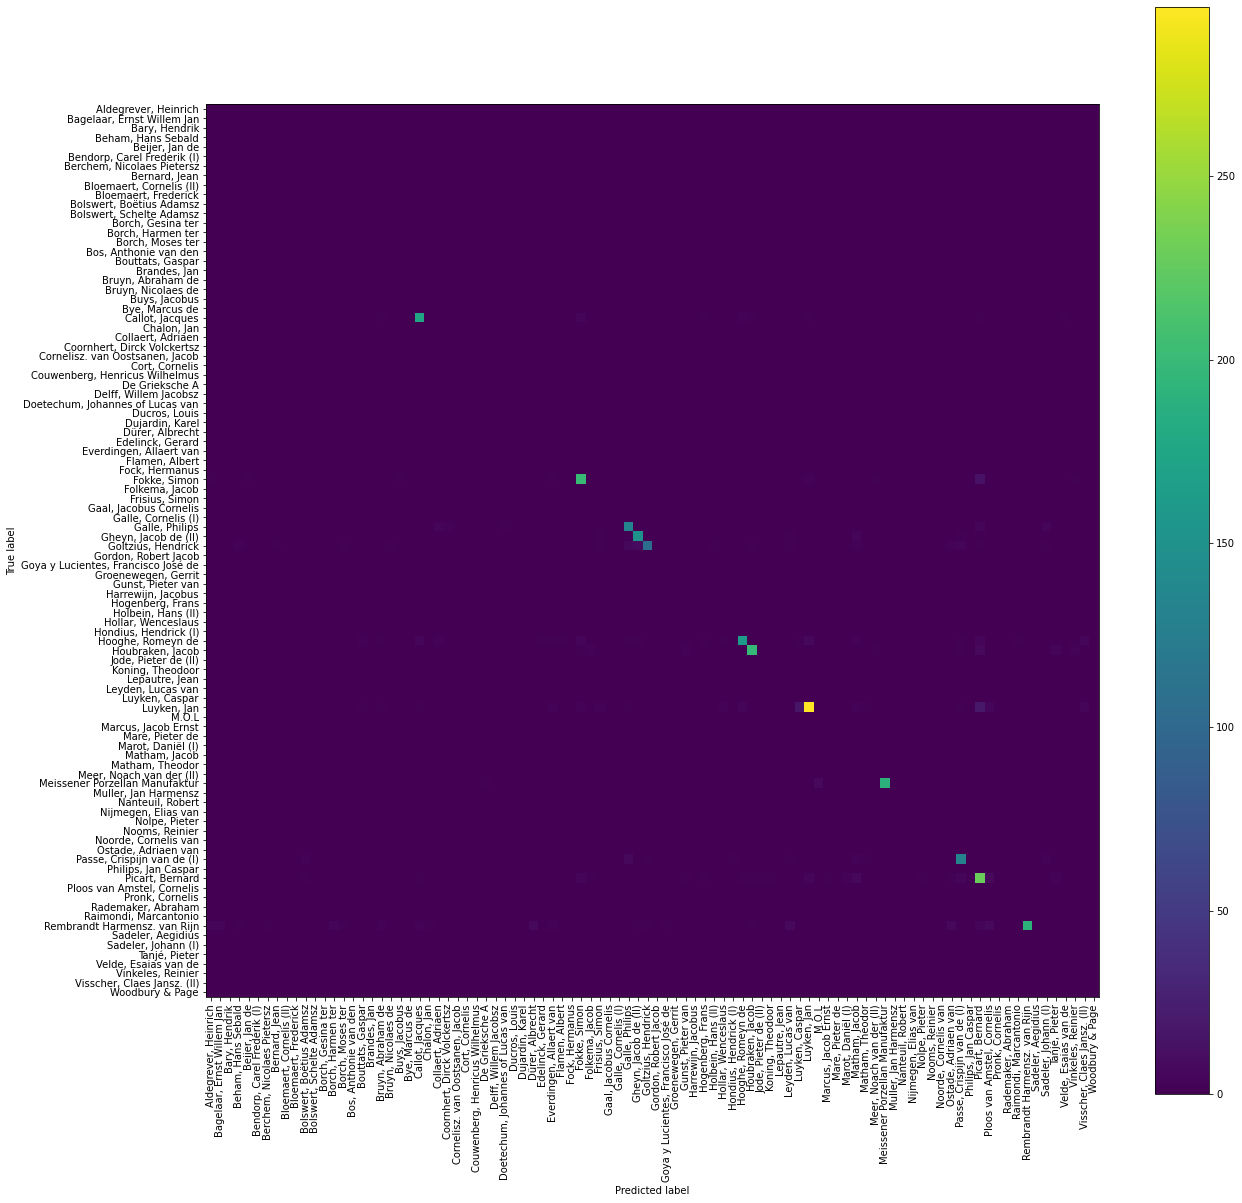

In [87]:
# sns.heatmap(res[['predicted label', 'true label']], annot=True)

fig, ax = plt.subplots(figsize=(20, 20))
ax.tick_params(axis='x', labelrotation=90)

cmd = ConfusionMatrixDisplay.from_predictions(res50['true label'], res50['predicted label'], include_values=False, ax=ax, xticks_rotation='vertical')